# SimpegEM1D VTEM Waveform

In [1]:
from simpegEM1D import *

In [2]:
from SimPEG import *
import numpy as np

In [3]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
dobs = np.load('dobs_3d.npy')


In [5]:
time_channels = np.vstack([
    [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    [470e-7, 598e-7, 726e-7, 886e-7, 1118e-7, 1454e-7, 1852e-7, 2344e-7, 2952e-7, 3706e-7, 4644e-7, 5814e-7, 7278e-7, 9112e-7, 11170e-7, 14292e-7, 17912e-7, 22460e-7, 28174e-7, 35356e-7, 44388e-7, 55750e-7, 7.00e-03, 8.80e-03]
]).T

In [6]:
waveform = np.vstack([
    np.r_[-10, -9.29, -8.41, -7.26, -5.28, -3.62, -2.33, -0.62, 0.00, 0.0266, 0.0276, 0.0286, 10.000]*1e-3,
    np.r_[0, 20, 40, 60, 80, 90, 95, 99, 100, 1.53, 0.566, 0.000, 0.000]/100.
]).T

In [7]:
time_input_currents = waveform[:-1, 0]
input_currents = waveform[:-1, 1]
times = time_channels[:-3, 1]

In [8]:
print(time_input_currents)

[-1.00e-02 -9.29e-03 -8.41e-03 -7.26e-03 -5.28e-03 -3.62e-03 -2.33e-03
 -6.20e-04  0.00e+00  2.66e-05  2.76e-05  2.86e-05]


In [9]:
print(input_currents)

[0.      0.2     0.4     0.6     0.8     0.9     0.95    0.99    1.
 0.0153  0.00566 0.     ]


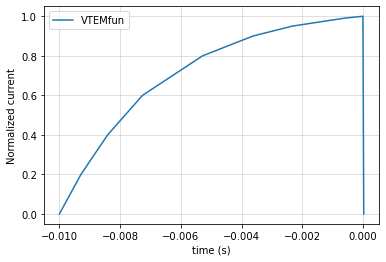

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(time_input_currents,input_currents,label='VTEMfun')
ax.set_xlabel("time (s)")
ax.set_ylabel("Normalized current")
ax.grid("k", alpha=0.5)
plt.legend()

In [11]:
area = 313.98
radius = np.sqrt(area/np.pi)
system_height = 39.8
rxloc = np.array([0, 0., 100+system_height], dtype=float)
srcloc = np.array([0., 0., 100+system_height], dtype=float)


In [12]:
print(radius)

9.997146496075098


In [13]:
type(rxloc)

numpy.ndarray

In [14]:
# cs,csz, ncx, ncz, npad = 5.0,1.0, 25, 31,17
# hz = [ (csz, ncz), (cs, npad, 1.3)]
hz = get_vertical_discretization_time(times, facter_tmax=0.5, factor_tmin=10.)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigz = -mesh1D.gridCC


In [15]:
#np.save('vectorCCx',mesh1D.vectorCCx)

In [16]:
TDsurvey = EM1DSurveyTD(
    rx_location = rxloc,
    src_location = srcloc,
    topo = np.r_[0.,0.,100.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'general',
    src_type = 'CircularLoop',
    a = radius,
    time = times,
    input_currents = input_currents,
    time_input_currents = time_input_currents,
    base_frequency=25,
    n_pulse=1
    )

In [17]:
sig_half = 1e-1
chi_half =0.
expmap = Maps.ExpMap(mesh1D)

In [18]:
sig = np.ones(TDsurvey.n_layer)*sig_half
mtrue = np.log(sig)
print(mtrue)

[-2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509]


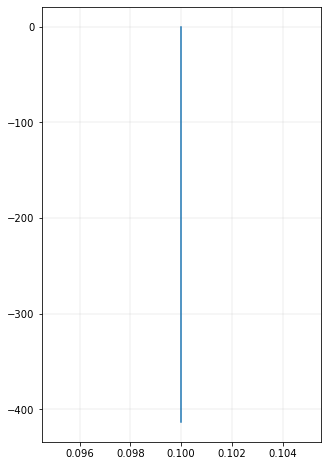

In [19]:
fig, ax = plt.subplots(1,1, figsize=(5, 8))
ax.plot(sig,depth)
ax.grid(which = 'major', linestyle='-', linewidth=0.2)

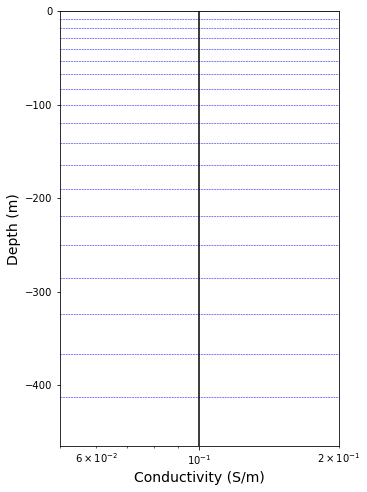

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D, showlayers=True)
#ax.set_ylim(-100,0)


In [21]:
%%time
prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
d_true = TDsurvey.dpred(mtrue)

Wall time: 71.2 ms


In [22]:
std = 0.05
floor = 1e-12
uncert = abs(dobs) * std + floor

In [23]:
dpred_3d= np.load('dpred_3d.npy')

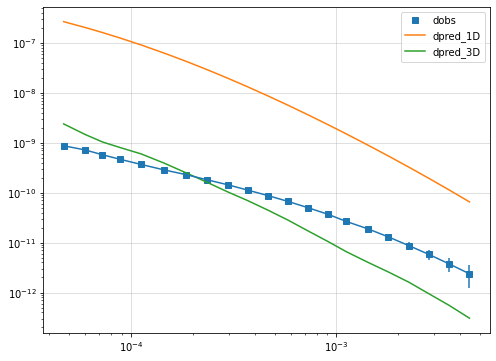

In [24]:
fig, ax = plt.subplots(1, 1,figsize=(8,6))

ax.loglog(time_channels[:-3, 1], dobs, "C0s", label="dobs")
plt.errorbar(time_channels[:-3, 1], dobs, yerr=uncert, color="C0")
ax.loglog(time_channels[:-3, 1], -d_true, "C1", label="dpred_1D")
ax.loglog(time_channels[:-3, 1], -dpred_3d, "C2", label="dpred_3D")
ax.grid('k', alpha=0.5)
ax.legend()

In [25]:
print(dpred_3d)

[-2.38084436e-09 -1.46303976e-09 -1.03624911e-09 -7.98974522e-10
 -5.98481343e-10 -3.88091227e-10 -2.49853013e-10 -1.61287138e-10
 -1.03780080e-10 -6.90270111e-11 -4.45358741e-11 -2.81547813e-11
 -1.70822922e-11 -1.04543243e-11 -6.56280681e-12 -3.98619676e-12
 -2.57170206e-12 -1.61586154e-12 -9.44280025e-13 -5.52698164e-13
 -3.06285600e-13]


In [26]:
print(d_true)

[-2.65668267e-07 -2.03114028e-07 -1.60944378e-07 -1.24809732e-07
 -9.09664580e-08 -6.20887948e-08 -4.27191136e-08 -2.91046550e-08
 -1.96356928e-08 -1.31015305e-08 -8.63761174e-09 -5.62350861e-09
 -3.61284612e-09 -2.29077507e-09 -1.49990878e-09 -8.86544995e-10
 -5.40831521e-10 -3.25580295e-10 -1.93366852e-10 -1.13219150e-10
 -6.52911886e-11]
